In [1]:
%%time
import sys, os

# get current directory
path = os.getcwd()

# get parent directory
parent_directory = os.path.sep.join(path.split(os.path.sep)[:-4])

# add utils folder to current working path
sys.path.append(parent_directory+"/subfunctions/utils")

# add integration folder to current working path
sys.path.append(parent_directory+"/subfunctions/integration")

# add 'FTLE3D' folder to current working path in order to access the functions
sys.path.append(parent_directory+"/demos/AdvectiveBarriers/FTLE3D")

Wall time: 0 ns


# Overview

In the following notebook we compute the finite time Lyapunov exponent (FTLE) on the three-dimensional, unsteady ABC-flow. The notebook is structured as follows:

1. Import data from the file 'ABC.mat' stored in the folder 'data'.
<br />
2. Define computational parameters (such as the number of cores) and data.
 <br />
3. Define spatio-temporal domain.
 <br />
4. Interpolate velocity from (discrete) gridded data.
 <br />
5. FTLE:

    * Compute gradient of flow map $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ over meshgrid using an auxiliary grid.
    <br />
    
    * Compute FTLE from maximum singular value $ \sigma_{max} $ of $ \mathbf{\nabla F}_{t_0}^{t_N}(\mathbf{x}_0) $ according to:
    \begin{equation}
    \mathrm{FTLE}_{t_0}^{t_N}(\mathbf{x}_0) = \dfrac{1}{t_N-t_0}\log(\sigma_{max}(\mathbf{x}_0))
    \end{equation}

# Import data

In [2]:
%%time
import scipy.io as sio

#Import velocity data from file in data-folder
mat_file = sio.loadmat('../../../../data/ABC/ABC_steady.mat')

U = mat_file['u']
V = mat_file['v']
W = mat_file['w']
x = mat_file['x']
y = mat_file['y']
z = mat_file['z'] 

Wall time: 117 ms


# Computational parameters and data

Here we define the computational parameters and the data.

In [3]:
import numpy as np

# number of cores to be used for parallel computing
Ncores = 4

# periodic boundary conditions
periodic_x = True
periodic_y = True
periodic_z = True
periodic = [periodic_x, periodic_y, periodic_z]

# steady velocity field
bool_unsteady = False

## compute meshgrid of dataset
X, Y, Z = np.meshgrid(x, y, z)

## resolution of meshgrid
dx_data = X[0,1,0]-X[0,0,0]
dy_data = Y[1,0,0]-Y[0,0,0]
dz_data = Z[0,0,1]-Z[0,0,0]

NY = Y.shape[0]
NX = X.shape[1]
NZ = Z.shape[2]

delta = [dx_data, dy_data, dz_data]

# Spatio-temporal domain

Here we define the spatio-temporal domain over which to consider the dynamical system.

In [4]:
%%time
# Initial time (in days)
t0 = 0 # float

# Final time (in days)
tN = 10 # float

# Time step-size (in days)
dt = 0.05 # float

# NOTE: For computing the backward FTLE field tN < t0 and dt < 0.

time = np.arange(t0, tN+dt, dt) # shape (Nt,)

# Length of time interval (in days)
lenT = abs(tN-t0) # float

# boundaries
xmin = 0 # float
xmax = 2*np.pi # float
ymin = 0 # float
ymax = 2*np.pi # float
zmin = 0 # float
zmax = 2*np.pi # float

# Resolution of meshgrid
Ny = 200 # int
Nx = 200 # int
Nz = 200 # int

x_domain = np.linspace(xmin, xmax, Nx, endpoint = True) # array (Nx, )
y_domain = np.linspace(ymin, ymax, Ny, endpoint = True) # array (Ny, )
z_domain = np.linspace(zmin, zmax, Nz, endpoint = True) # array (Nz, )

dx = x_domain[1]-x_domain[0]
dy = y_domain[1]-y_domain[0]
dz = z_domain[1]-z_domain[0]

X_domain, Y_domain, Z_domain = np.meshgrid(x_domain, y_domain, z_domain) # array (Ny, Nx, Nz)

Ny = X_domain.shape[0] # int
Nx = X_domain.shape[1] # int
Nz = X_domain.shape[2] # int

Wall time: 24.9 ms


# Interpolate Velocity

In order to evaluate the velocity field at arbitrary locations and times, we must interpolate the discrete velocity data. The interpolation with respect to time and space is linear.

In [5]:
%%time
# Import interpolation function for unsteady flow field
# Import interpolation function for unsteady flow field
from ipynb.fs.defs.Interpolant import interpolant_steady

# Interpolate velocity data using cubic spatial interpolation
#Interpolant = interpolant_steady(X, Y, Z, U, V, W)

#Interpolant_u = Interpolant[0]
#Interpolant_v = Interpolant[1]
#Interpolant_w = Interpolant[2]

import tricubic

Interpolant_u = tricubic.tricubic(list(U), [NY,NX,NZ]) #initialize interpolator with input data on cubic grid
Interpolant_v = tricubic.tricubic(list(V), [NY,NX,NZ]) #initialize interpolator with input data on cubic grid
Interpolant_w = tricubic.tricubic(list(W), [NY,NX,NZ]) #initialize interpolator with input data on cubic grid

Wall time: 79.8 ms


# FTLE

Next, we compute the FTLE over the meshgrid over the given time-interval.
We iterate over all initial conditions and first calculate the gradient of the flow map using an auxiliary grid. From the maximum singular value of the gradient of the flow map we can then compute the FTLE.

In [6]:
%%time
# Import function to compute gradient of flow map
from ipynb.fs.defs.gradient_flowmap import gradient_flowmap

# Import function to compute finite time Lyapunov exponent (FTLE)
from ipynb.fs.defs.FTLE import _FTLE

# Import package for parallel computing
from joblib import Parallel, delayed

# Define ratio of auxiliary grid spacing vs original grid_spacing
aux_grid_ratio = .1 # float between [1/100, 1/5]
aux_grid = [aux_grid_ratio*dx, aux_grid_ratio*dy, aux_grid_ratio*dz] # list (3, )

# Vectorize initial conditions by arranging them to a vector of size (Nx*Ny*Nz, )
x0 = X_domain[:,:,0].ravel() # array (Nx*Ny*Nz,)
y0 = Y_domain[:,:,0].ravel() # array (Nx*Ny*Nz,)
z0 = Z_domain[:,:,0].ravel() # array (Nx*Ny*Nz,)

# Initial conditions
X0 = np.array([x0, y0, z0]) # array (3, Nx*Ny*Nz)

#X0 = np.array([1.46, 0.1, 0]).reshape(3,-1) # array (3, Nx*Ny*Nz)

# Compute gradient of flow map
gradFmap = gradient_flowmap(time, X0, X, Y, Z, Interpolant_u, Interpolant_v, Interpolant_w, periodic, bool_unsteady, aux_grid) # array (Nt, 3, 3, Nx*Ny)

# Extract gradient from t0 to tN
gradFmap_t0_tN = gradFmap[-1,:, :, :] # array (Nt, 3, 3, Nx*Ny)

#print(gradFmap_t0_tN)
#print(_FTLE(gradFmap_t0_tN[:,:,i], lenT))

# Compute FTLE
FTLE = [] # list (Nx*Ny*Nz,)
for i in range(gradFmap_t0_tN.shape[2]):
    FTLE.append(_FTLE(gradFmap_t0_tN[:,:,i], lenT))

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

Wall time: 23min 28s


In [7]:
# Reshape array from vectorized form to structured meshgrid
X0_gridded = x0.reshape((Ny, Nx)) # array (Ny, Nx, Nz)
Y0_gridded = y0.reshape((Ny, Nx)) # array (Ny, Nx, Nz)
Z0_gridded = z0.reshape((Ny, Nx)) # array (Ny, Nx, Nz)
FTLE = np.array(FTLE).reshape((Ny, Nx)) # array (Ny, Nx, Nz)

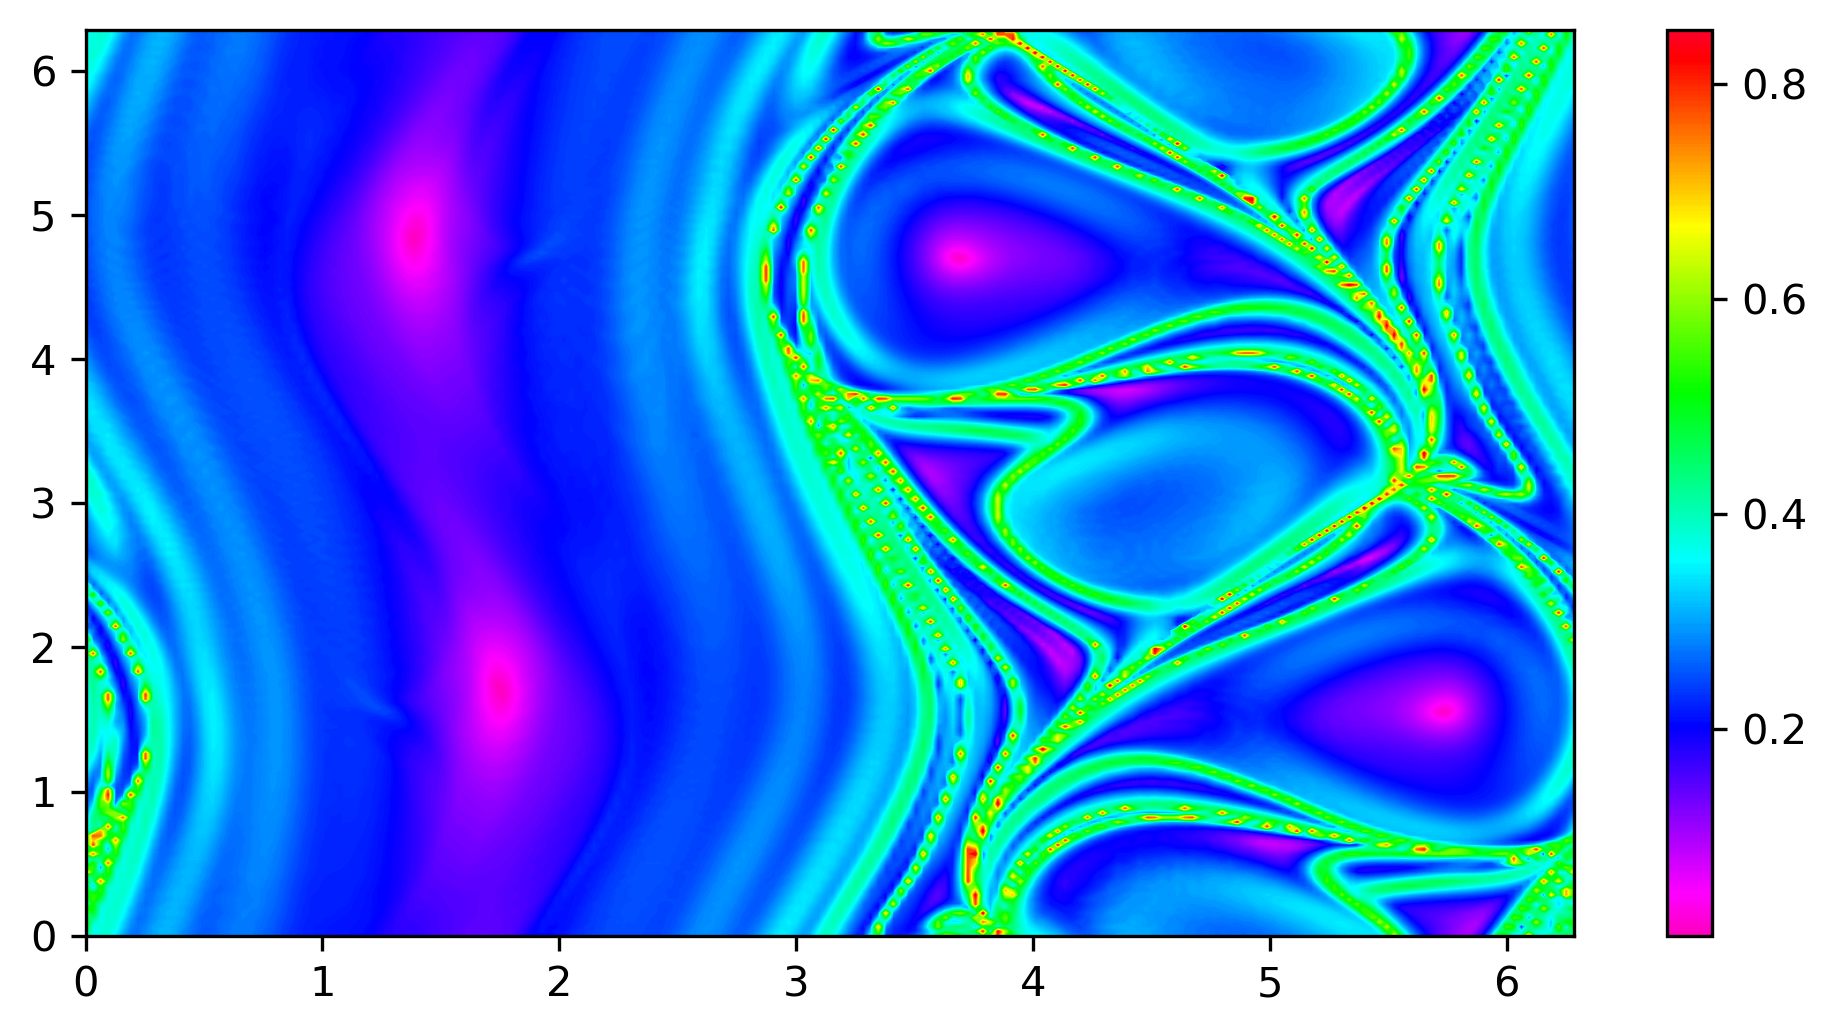

In [8]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (8, 4), dpi = 300)
ax = plt.axes()
cax = ax.contourf(X0_gridded, Y0_gridded, FTLE, levels = 500, cmap = "gist_rainbow_r")
plt.colorbar(cax, ticks = np.arange(0, 3, 0.2))
plt.show()